In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torch.cuda.amp import GradScaler, autocast

import cv2

import albumentations
from albumentations.pytorch import ToTensorV2

from sklearn.metrics import confusion_matrix, roc_auc_score, average_precision_score

from tqdm import tqdm
import argparse
import os, sys, yaml

sys.path.append('/workspace/siim-rsna-2021')
from src.logger import setup_logger, LOGGER
from src.meter import mAPMeter, AUCMeter, APMeter, AverageValueMeter
from src.utils import plot_sample_images

# import neptune.new as neptune
import wandb
import pydicom

import time
from contextlib import contextmanager


import timm

import warnings

target_columns = [
    "Negative for Pneumonia", "Typical Appearance", "Indeterminate Appearance", "Atypical Appearance", "is_none"
]

In [2]:
df = pd.read_csv('/workspace/data/df_train_study_level_npy640_3_w_bbox.csv')
df.head()

,id,x,y,w,h,study_id,image_id,have_box,dicom_path,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,cv,npy_path,is_none
0,04f41a8958f7_image,688.06282,966.82563,518.48212,1130.17438,6e4a0581cefe,04f41a8958f7,1,/workspace/data/train/6e4a0581cefe/018ed20fa9c...,0,1,0,0,0,/workspace/data/train_640_2/04f41a8958f7.png,0
1,04f41a8958f7_image,2482.36026,1636.77436,652.47168,652.47168,6e4a0581cefe,04f41a8958f7,1,/workspace/data/train/6e4a0581cefe/018ed20fa9c...,0,1,0,0,0,/workspace/data/train_640_2/04f41a8958f7.png,0
2,04f41a8958f7_image,1235.67308,1628.03597,509.74353,559.26147,6e4a0581cefe,04f41a8958f7,1,/workspace/data/train/6e4a0581cefe/018ed20fa9c...,0,1,0,0,0,/workspace/data/train_640_2/04f41a8958f7.png,0
3,0572ef0d0c1a_image,1818.65264,233.50598,613.04395,839.53784,adbfed2da701,0572ef0d0c1a,1,/workspace/data/train/adbfed2da701/e2fa197720c...,0,1,0,0,3,/workspace/data/train_640_2/0572ef0d0c1a.png,0
4,0572ef0d0c1a_image,598.60492,61.37052,688.54175,881.81674,adbfed2da701,0572ef0d0c1a,1,/workspace/data/train/adbfed2da701/e2fa197720c...,0,1,0,0,3,/workspace/data/train_640_2/0572ef0d0c1a.png,0


In [3]:

# =============================================================================
# Dataset
# =============================================================================

class CustomDataset(Dataset):
    def __init__(self,
                 df,
                 image_size,
                 transform=None,
                 mode="train",
                 clahe=False,
                 mix=False,
                 use_npy=False,
                 ):

        self.df = df.reset_index(drop=True)
        self.image_size = image_size
        self.transform = transform

        self.mode = mode
        self.clahe = clahe
        self.mix = mix
        if self.clahe or self.mix:
            self.clahe_transform = cv2.createCLAHE(clipLimit=10.0, tileGridSize=(16, 16))

        self.cols = target_columns
        self.use_npy = use_npy

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]

        if self.use_npy:
            # images = np.load(row.npy_path)
            images = cv2.imread(row.npy_path)
        else:
            images = pydicom.read_file(row.dicom_path).pixel_array

        if self.clahe:
            single_channel = images[:, :, 0].astype(np.uint8)
            single_channel = self.clahe_transform.apply(single_channel)
            images = np.array([
                single_channel,
                single_channel,
                single_channel
            ]).transpose(1, 2, 0)
        elif self.mix:
            single_channel = images[:, :, 0].astype(np.uint8)
            clahe_channel = self.clahe_transform.apply(single_channel)
            hist_channel = cv2.equalizeHist(single_channel)
            images = np.array([
                single_channel,
                clahe_channel,
                hist_channel
            ]).transpose(1, 2, 0)

        if self.transform is not None:
            images = self.transform(image=images)['image'] / 255                
        else:
            images = images.transpose(2, 0, 1)

        label = row[self.cols].values.astype(np.float16)
        return {
            "image": torch.tensor(images, dtype=torch.float),
            # "image": images,
            "target": torch.tensor(label, dtype=torch.float)
        }


In [21]:

def get_train_transforms(image_size):
    return albumentations.Compose([
           albumentations.ShiftScaleRotate(p=0.5),
#            albumentations.RandomResizedCrop(image_size, image_size, scale=(0.7, 1), p=1),
           albumentations.HorizontalFlip(p=0.5),
           albumentations.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=5, val_shift_limit=5, p=0.5),
           albumentations.RandomBrightnessContrast(brightness_limit=(-0.2,0.2), contrast_limit=(-0.2, 0.2), p=0.5),
           albumentations.CLAHE(clip_limit=(1, 4), p=0.5),
        #    albumentations.OneOf([
        #        albumentations.OpticalDistortion(distort_limit=1.0),
        #        albumentations.GridDistortion(num_steps=5, distort_limit=1.),
        #        albumentations.ElasticTransform(alpha=3),
        #    ], p=0.2),
           albumentations.OneOf([
               albumentations.GaussNoise(var_limit=[10, 50]),
               albumentations.GaussianBlur(),
               albumentations.MotionBlur(),
            #    albumentations.MedianBlur(),
           ], p=0.1),
          albumentations.Resize(image_size, image_size),
        #   albumentations.OneOf([
        #       albumentations.augmentations.transforms.JpegCompression(),
        #       albumentations.augmentations.transforms.Downscale(scale_min=0.1, scale_max=0.15),
        #   ], p=0.2),
        #   albumentations.imgaug.transforms.IAAPiecewiseAffine(p=0.2),
        #   albumentations.imgaug.transforms.IAASharpen(p=0.2),
          albumentations.Cutout(max_h_size=int(image_size * 0.1), max_w_size=int(image_size * 0.1), num_holes=5, p=0.5),
        #   albumentations.Normalize(
        #       mean=[0.485, 0.456, 0.406],
        #       std=[0.229, 0.224, 0.225],
        #   ),
          ToTensorV2(p=1)
])


def get_train_transforms2(image_size):
    return albumentations.Compose([
           albumentations.ShiftScaleRotate(p=0.5),
#            albumentations.RandomResizedCrop(image_size, image_size, scale=(0.7, 1), p=1),
           albumentations.HorizontalFlip(p=0.5),
           albumentations.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=5, val_shift_limit=5, p=0.5),
           albumentations.RandomBrightnessContrast(brightness_limit=(-0.2,0.2), contrast_limit=(-0.2, 0.2), p=0.5),
           albumentations.CLAHE(clip_limit=(1, 4), p=0.5),
        #    albumentations.OneOf([
        #        albumentations.OpticalDistortion(distort_limit=1.0),
        #        albumentations.GridDistortion(num_steps=5, distort_limit=1.),
        #        albumentations.ElasticTransform(alpha=3),
        #    ], p=0.2),
           albumentations.OneOf([
               albumentations.GaussNoise(var_limit=[10, 50]),
               albumentations.GaussianBlur(),
               albumentations.MotionBlur(),
            #    albumentations.MedianBlur(),
           ], p=0.1),
          albumentations.Resize(image_size, image_size),
        #   albumentations.OneOf([
        #       albumentations.augmentations.transforms.JpegCompression(),
        #       albumentations.augmentations.transforms.Downscale(scale_min=0.1, scale_max=0.15),
        #   ], p=0.2),
        #   albumentations.imgaug.transforms.IAAPiecewiseAffine(p=0.2),
        #   albumentations.imgaug.transforms.IAASharpen(p=0.2),
          albumentations.Cutout(max_h_size=int(image_size * 0.1), max_w_size=int(image_size * 0.1), num_holes=5, p=0.5),
        #   albumentations.Normalize(
        #       mean=[0.485, 0.456, 0.406],
        #       std=[0.229, 0.224, 0.225],
        #   ),
          ToTensorV2(p=1)
])


In [22]:
train_dataset = CustomDataset(df=df, image_size=512,
                              transform=get_train_transforms(512), use_npy=True, mode="train")

In [23]:
data = train_dataset[0]["image"].numpy().transpose(1, 2, 0)

<ipython-input-3-438462460ecd>:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "image": torch.tensor(images, dtype=torch.float),


In [24]:
data.shape

(512, 512, 3)

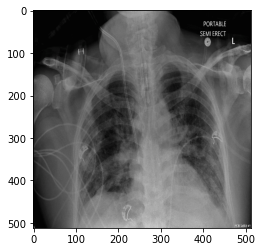

In [25]:
plt.figure()
plt.imshow(data)
plt.show()

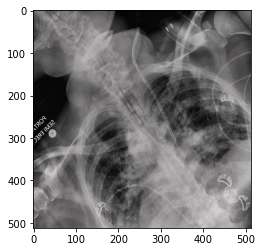

In [20]:
plt.figure()
plt.imshow(data)
plt.show()

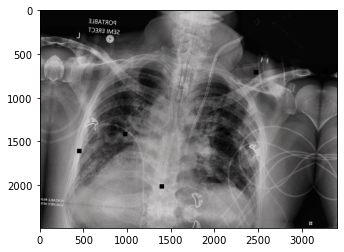

In [15]:
plt.figure()
plt.imshow(data)
plt.show()